<a href="https://colab.research.google.com/github/anthng/time-series-forecasting/blob/main/ARIMA_SARIMA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

try:
    from statsmodels.tsa.arima.model import ARIMA
    import pmdarima as pm
except:
    !pip3 install pmdarima
    !pip3 install 'statsmodels==0.12.1'
    from statsmodels.tsa.arima.model import ARIMA
    import pmdarima as pm

import statsmodels.api as sm


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/anthng/time-series-forecasting/main/disease_vn.csv', parse_dates=[0])[['date1', 'diarrhoea']]
df['date1'] = pd.to_datetime(df["date1"].dt.strftime('%Y-%m-%d'))
df = df.drop_duplicates('date1')

df = df.sort_values('date1')
df

,date1,diarrhoea
0,1997-01-15,827
55,1997-02-15,1513
108,1997-03-15,2335
160,1997-04-15,1313
213,1997-05-15,3161
...,...,...
12767,2016-09-15,286
12822,2016-10-15,224
12877,2016-11-15,223
12932,2016-12-15,200


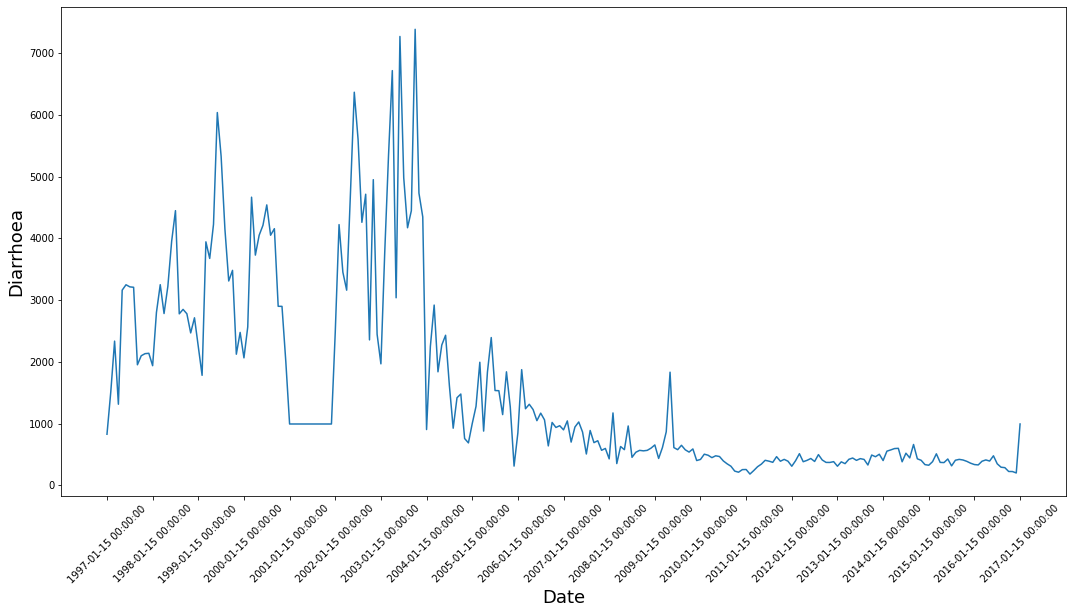

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['diarrhoea']))
plt.xticks(range(0,df.shape[0],12),df['date1'].loc[::12],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Diarrhoea',fontsize=18)
plt.show()

In [ ]:
df['diarrhoea'].describe()

count     241.000000
mean     1558.236515
std      1552.718309
min       182.000000
25%       420.000000
50%       898.000000
75%      2335.000000
max      7385.000000
Name: diarrhoea, dtype: float64

In [ ]:
df_clean = df.set_index('date1')
n = int(df_clean.shape[0]*0.6)
train_df = df_clean[:n][['diarrhoea']]
test_df = df_clean[n:][['diarrhoea']]


train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

# Training

# ARIMA

In [ ]:
arima_model = pm.auto_arima(train, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=12, stepwise=True, seasonal=False, information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 2021, n_fits=30)

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.189, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.301, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43.552, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.189, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45.549, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=45.549, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=47.466, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=41.560, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=43.557, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=43.557, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=44.303, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=45.472, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.048 seconds


In [ ]:
test_arima = test.copy()
train_arima = train.copy()

history = [x for x in train_arima.values]
predictions = list()
# walk-forward validation
for t in range(len(test_arima)):
	model = ARIMA(history, order=(0,1,1))
	arima_results = model.fit()
	output = arima_results.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_arima.iloc[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
 
predictions = np.array(predictions)

In [ ]:
test_arima['pred'] = predictions
test_arima['y_diarrhoea'] = scaler.inverse_transform(test_arima.diarrhoea.values.reshape(-1,1))
test_arima['y_pred'] = scaler.inverse_transform(test_arima.pred.values.reshape(-1,1))
test_arima

,diarrhoea,pred,y_diarrhoea,y_pred
date1,,,,
2009-01-15,-0.903025,-0.921909,654.0,587.207229
2009-02-15,-0.964942,-0.910303,435.0,628.257480
2009-03-15,-0.914900,-0.943878,612.0,509.502675
2009-04-15,-0.842805,-0.926073,867.0,572.479130
2009-05-15,-0.569975,-0.874912,1832.0,753.434564
...,...,...,...,...
2016-09-15,-1.007068,-0.994856,286.0,329.192836
2016-10-15,-1.024597,-1.002310,224.0,302.831242
2016-11-15,-1.024880,-1.015913,223.0,254.716337


The Mean Squared Error of ARIMA is 32496.536599414518


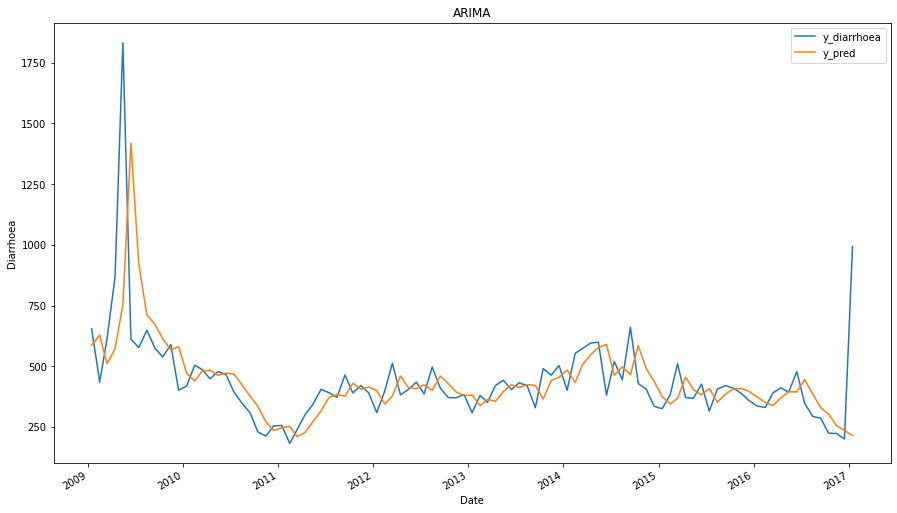

In [ ]:
y_forecasted = test_arima.y_pred.values
y_truth = test_arima.y_diarrhoea.values


# Compute the mean square error
mse_arima = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of ARIMA is {}'.format(mse_arima))
test_arima[['y_diarrhoea', 'y_pred']].plot(title='ARIMA',figsize=(15,9))
plt.xlabel("Date")
plt.ylabel("Diarrhoea")
plt.show()

# SARIMA

In [ ]:
sarima_model = pm.auto_arima(train, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=12, stepwise=True, seasonal=True, information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 2021, n_fits=20)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=140.682, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=84.122, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=110.826, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=66.918, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=59.756, Time=1.08 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=57.687, Time=2.03 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=58.229, Time=2.91 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=8.34 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=54.039, Time=3.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=2.63 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=58.039, Time=5.94 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=3.80 se

In [ ]:
import statsmodels.api as sm

del history
test_sarima = test.copy()
train_sarima = train.copy()

history = [x for x in train_sarima.values]
predictions = list()

for t in range(len(test_sarima)):
	model = sm.tsa.statespace.SARIMAX(history,order=(0,1,1), seasonal_order=(2, 1, 1, 12))
 
	sarima_results = model.fit(max_iter=200, method='powell')
	output = sarima_results.forecast()
	yhat = output[0]
	predictions.append(yhat)
 
	obs = test_sarima.iloc[t]
	history.append(obs)

	# print('predicted=%f, expected=%f' % (yhatpredictions = np.array(predictions)
predictions = np.array(predictions)

Optimization terminated successfully.
         Current function value: 0.142736
         Iterations: 7
         Function evaluations: 460
Optimization terminated successfully.
         Current function value: 0.140849
         Iterations: 8
         Function evaluations: 515
Optimization terminated successfully.
         Current function value: 0.139027
         Iterations: 8
         Function evaluations: 514
Optimization terminated successfully.
         Current function value: 0.136051
         Iterations: 8
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 0.132658
         Iterations: 8
         Function evaluations: 518
Optimization terminated successfully.
         Current function value: 0.132929
         Iterations: 8
         Function evaluations: 519
Optimization terminated successfully.
         Current function value: 0.137009
         Iterations: 7
         Function evaluations: 461
Optimization terminated successful

In [ ]:
test_sarima['pred'] = predictions
test_sarima['y_diarrhoea'] = scaler.inverse_transform(test_sarima.diarrhoea.values.reshape(-1,1))
test_sarima['y_pred']= scaler.inverse_transform(test_sarima.pred.values.reshape(-1,1))
test_sarima

,diarrhoea,pred,y_diarrhoea,y_pred
date1,,,,
2009-01-15,-0.903025,-1.101191,654.0,-46.912090
2009-02-15,-0.964942,-0.764877,435.0,1142.629461
2009-03-15,-0.914900,-0.786034,612.0,1067.798696
2009-04-15,-0.842805,-0.921239,867.0,589.579334
2009-05-15,-0.569975,-0.858908,1832.0,810.041373
...,...,...,...,...
2016-09-15,-1.007068,-0.999895,286.0,311.369891
2016-10-15,-1.024597,-1.000669,224.0,308.632937
2016-11-15,-1.024880,-1.022402,223.0,231.765762


The Mean Squared Error of SARIMA is 79868.01397761707


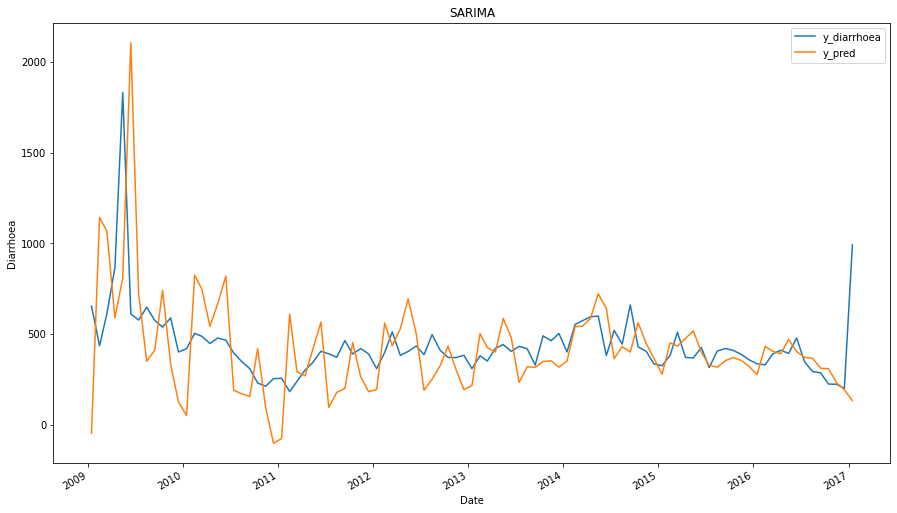

In [ ]:
y_forecasted = test_sarima.y_pred.values
y_truth = test_sarima.y_diarrhoea.values


# Compute the mean square error
mse_sarima = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of SARIMA is {}'.format(mse_sarima))
test_sarima[['y_diarrhoea', 'y_pred']].plot(title='SARIMA',figsize=(15,9))
plt.xlabel("Date")
plt.ylabel("Diarrhoea")
plt.show()

# LSTM

In [ ]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Lookback period
lookback = 6
X_train, Y_train = create_dataset(train.values, lookback)
X_test, Y_test = create_dataset(test.values, lookback)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential()
model.add(LSTM(12, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history=model.fit(X_train, Y_train, epochs=60, batch_size=1, verbose=0)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test, batch_size=1)

predictions = scaler.inverse_transform(test_pred)
groundtruth = scaler.inverse_transform([Y_test])

mse_lstm = ((predictions - groundtruth) ** 2).mean()
print('The Mean Squared Error of LSTM is {}'.format(mse_lstm))

The Mean Squared Error of LSTM is 20796.543715913576


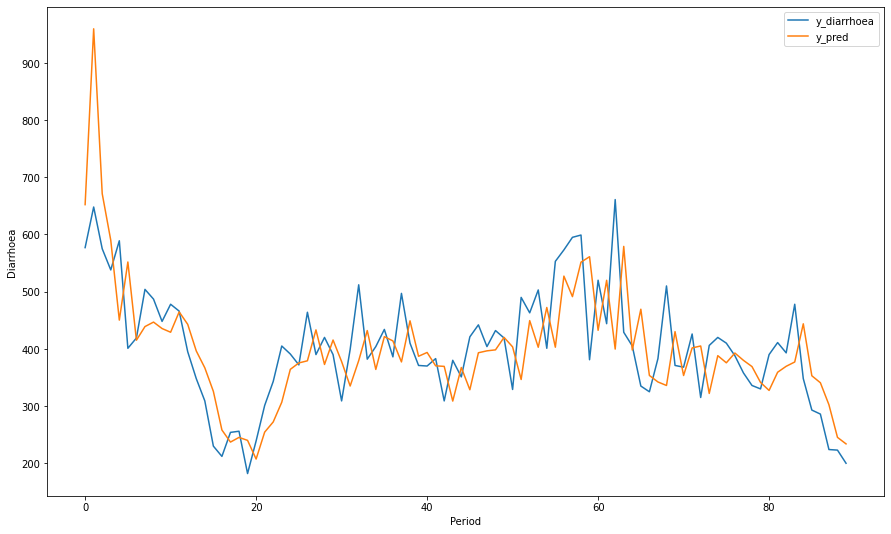

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(groundtruth.reshape(-1,1), label='y_diarrhoea')
plt.plot(predictions, label='y_pred')
plt.xlabel("Period")
plt.ylabel("Diarrhoea")
plt.legend()
plt.show()

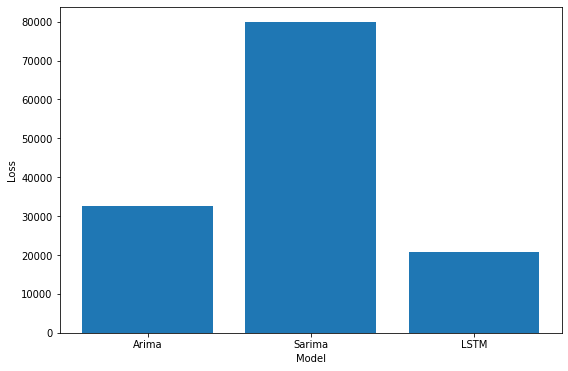

In [ ]:
plt.figure(figsize=(9,6))
losses = [mse_arima, mse_sarima, mse_lstm]

plt.bar(['Arima', 'Sarima', 'LSTM'],losses)
plt.xlabel('Model')
plt.ylabel('Loss')
plt.show()